In [2]:
#.libPaths("~/R/prs-libs")
.libPaths("/home/daniel/R/x86_64-pc-linux-gnu-library/4.2")
library(eurostat)
library(vtable)
library(ggplot2)
library(cowplot)
library(moments)

Loading required package: kableExtra



#### Příprava dat

Aplikujeme vzorec, který je uveden na courses

In [3]:
K = 17
L = nchar("Dostal")
M = (( (K+L)*47 ) %% 11 ) + 1
M

[1] 4

Ze vzorce vyšlo a číslo 4 a to odpovídá Bulharsku. Stáhneme si zadaný eurostat dataset.

In [4]:
data_id = "demo_r_pjanaggr3"
df <- get_eurostat(id=data_id)
head(df)

unit,sex,age,geo,time,values
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
NR,F,TOTAL,AT,2022-01-01,4553444
NR,F,TOTAL,AT1,2022-01-01,2000081
NR,F,TOTAL,AT11,2022-01-01,151557
NR,F,TOTAL,AT111,2022-01-01,19074
NR,F,TOTAL,AT112,2022-01-01,83093
NR,F,TOTAL,AT113,2022-01-01,49390


Z datasetu vybereme pouze záznamy z Bulharska a roku 2021 týkajících se zvlášť mužů a žen.

In [5]:
#get data from bulgaria and year 2021
df = df[substr(df$geo, 1, 2) == "BG" & df$time == "2021-01-01" & df$sex!="T",]

Sloupce pohlaví a věk převedeme na faktory a z datasetu odebereme ostatní nepotřebné sloupce. Navíc, si přejmenujeme sloupec *values* na *population*.

In [6]:
#transform to factors and remove unnecessary columns
df$sex = as.factor(df$sex)
df$age = as.factor(df$age)
df = df[c("sex", "age", "geo", "values")]
colnames(df) <- c("sex", "age", "geo", "population")

Vypíšeme aktuální stav datasetu *df*

In [7]:
paste("Number of rows: ", nrow(df))
summary(df)

[1] "Number of rows:  370"

 sex         age         geo              population     
 F:185   TOTAL :74   Length:370         Min.   :      0  
 M:185   UNK   :74   Class :character   1st Qu.:   8433  
         Y_GE65:74   Mode  :character   Median :  35480  
         Y_LT15:74                      Mean   : 149547  
         Y15-64:74                      3rd Qu.: 100535  
                                        Max.   :3566833  

Ve sloupci *age* se vyskytuje hodnota *UNK* značící neznámý věk. Podíváme se, jestli se v datasetu vyskytují nějaké záznamy s neznámým věkem (jestli je někde v řádku s *UNK* nenulový počet obyvatel).

In [8]:
unknown = subset(df, age == "UNK" & population != 0)
paste("Number of regions with unknown age: ", nrow(unknown))

[1] "Number of regions with unknown age:  0"

Věk je všude známý a záznamy s hodnotou *UKN* jsou proto zbytečné a nepřidávají nám žádné další informace. Tyto řádky z datasetu odstraníme. Následně aktualizujeme *age* faktor. 

In [9]:
df = subset(df, age != "UNK")
#update factor
df$age = factor(df$age)

### Úloha 1

In [10]:
paste("Number of rows: ", nrow(df))
summary(df)

[1] "Number of rows:  296"

 sex         age         geo              population     
 F:148   TOTAL :74   Length:296         Min.   :   4746  
 M:148   Y_GE65:74   Class :character   1st Qu.:  21036  
         Y_LT15:74   Mode  :character   Median :  54762  
         Y15-64:74                      Mean   : 186934  
                                        3rd Qu.: 131326  
                                        Max.   :3566833  

Zbylo nám 296 záznamů. Každý záznam popisuje, kolik v daném regionu Bulharska žilo lidí s daným věkem a pohlavím začátkem roku 2021.

Dále si ještě data rozdělíme na jednotlivé NUTS skupiny, aby se nám nemíchaly regiony různých velikostí.

In [11]:
nuts3 = subset(df, nchar(geo) == 5)
nuts2 = subset(df, nchar(geo) == 4)
nuts1 = subset(df, nchar(geo) == 3)
BG = subset(df, nchar(geo) == 2)

Zobrazíme si základní statistiky pro NUTS3 regiony.

In [12]:
summ <- c('mean(x)', 'sd(x)', 'min(x)', 'pctile(x)[25]', 'median(x)', 'pctile(x)[75]', 
          'max(x)', 'IQR(x)', 'skewness(x)', 'kurtosis(x)-3')
sumtable(subset(nuts3, age == "TOTAL", select=c("population","sex")), 
         out="return", summ=summ, group="sex", group.long=T, factor.numeric=TRUE)

Variable,Mean,Sd,Min,Pctile[25],Median,Pctile[75],Max,IQR,Skewness,Kurtosis-3
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
sex: F,,,,,,,,,,
population,127386.9,127818.349,41725,59821.25,87939,123031,681214,63209.75,3.219,10.945
,,,,,,,,,,
sex: M,,,,,,,,,,
population,119632.7,117536.39,39487,56895.5,83100.5,118651,627198,61755.5,3.185,10.762


Z dat to vypadá, že žen je o něco víc. Průměrná populace žen napříč NUTS3 regiony je 127 tisíc, kdežto u mužů pouze 119 tisíc. Stejně tak minimum, maximum i medián mají ženy vyšší. Mezikvartilové rozpětí je u žen od 59 821 do 123 031 a u mužů od 56 895 do 118 651.
Medián a průměr se poměrně razantně liší - je pravděpodobné, že v datech existuje pár regionů s obrovskou populací, které táhnou průměr směrem nahoru.

Šikmost je u obou pohlaví okolo 3.2, z toho plyne, že naše rozdělení je asymetrické a je sešikmené směrem doleva - majorita hodnot leží pod průměrem - opět kvůli tomu, že většina regionů má populaci nižší a existuje malé množství hustě osídlených oblastí.
Špičatost u obou rozdělení vyšla téměř 11. Z toho plyne, že v rozdělení bude existovat místo, kde je koncetrováno veliké množství hodnot (populací jednotlivých regionů) v porovnání s normálním rozdělením.



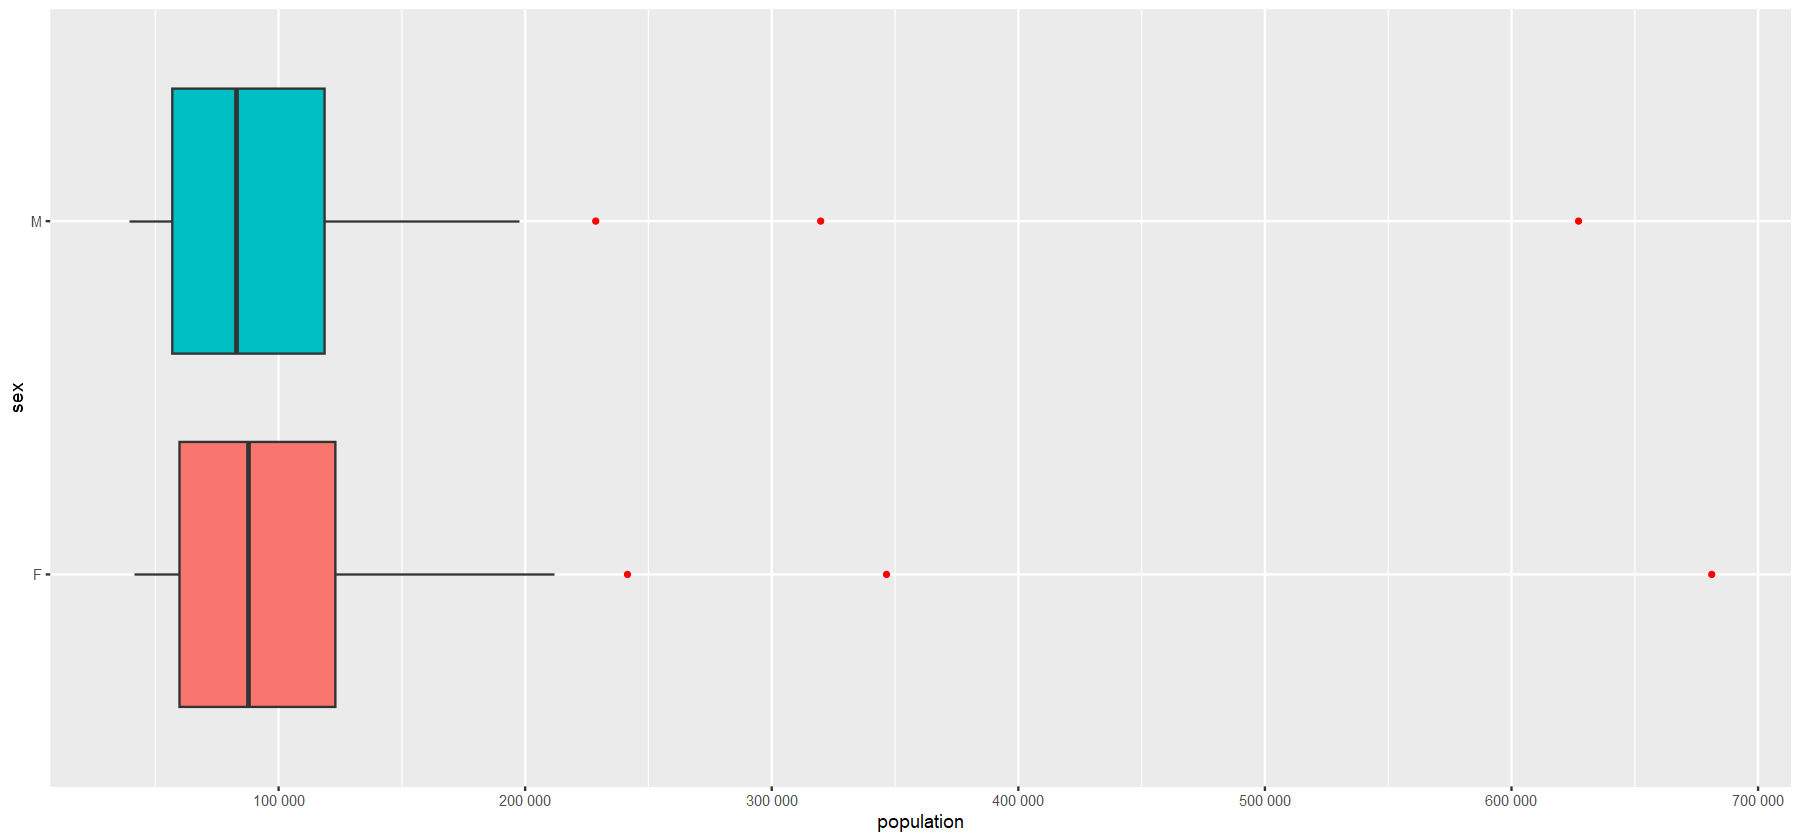

In [13]:
nuts3_total = subset(nuts3, age == "TOTAL")
options(repr.plot.width = 15, repr.plot.height = 7)
p = ggplot(nuts3_total, aes(x=population, y=sex, fill=sex)) +
        geom_boxplot(outlier.color="red", show.legend=F, outlier.size = 1) + 
        scale_x_continuous(labels = scales::number, n.breaks=10)
plot(p)

Grafy mužů a žen vypadají dost podobně. U obou je pár dost výrazných odlehných hodnot, které jsou pravděpodobně hustě osídlené oblasti - velká města. Kvůli odlehlým hodnotám jsou ale *boxploty* dost malé. Zkusíme proto *boxplot* vykreslit znovu, ale bez odlehlých hodnot.

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"Removed 7 rows containing non-finite values (`stat_boxplot()`)."


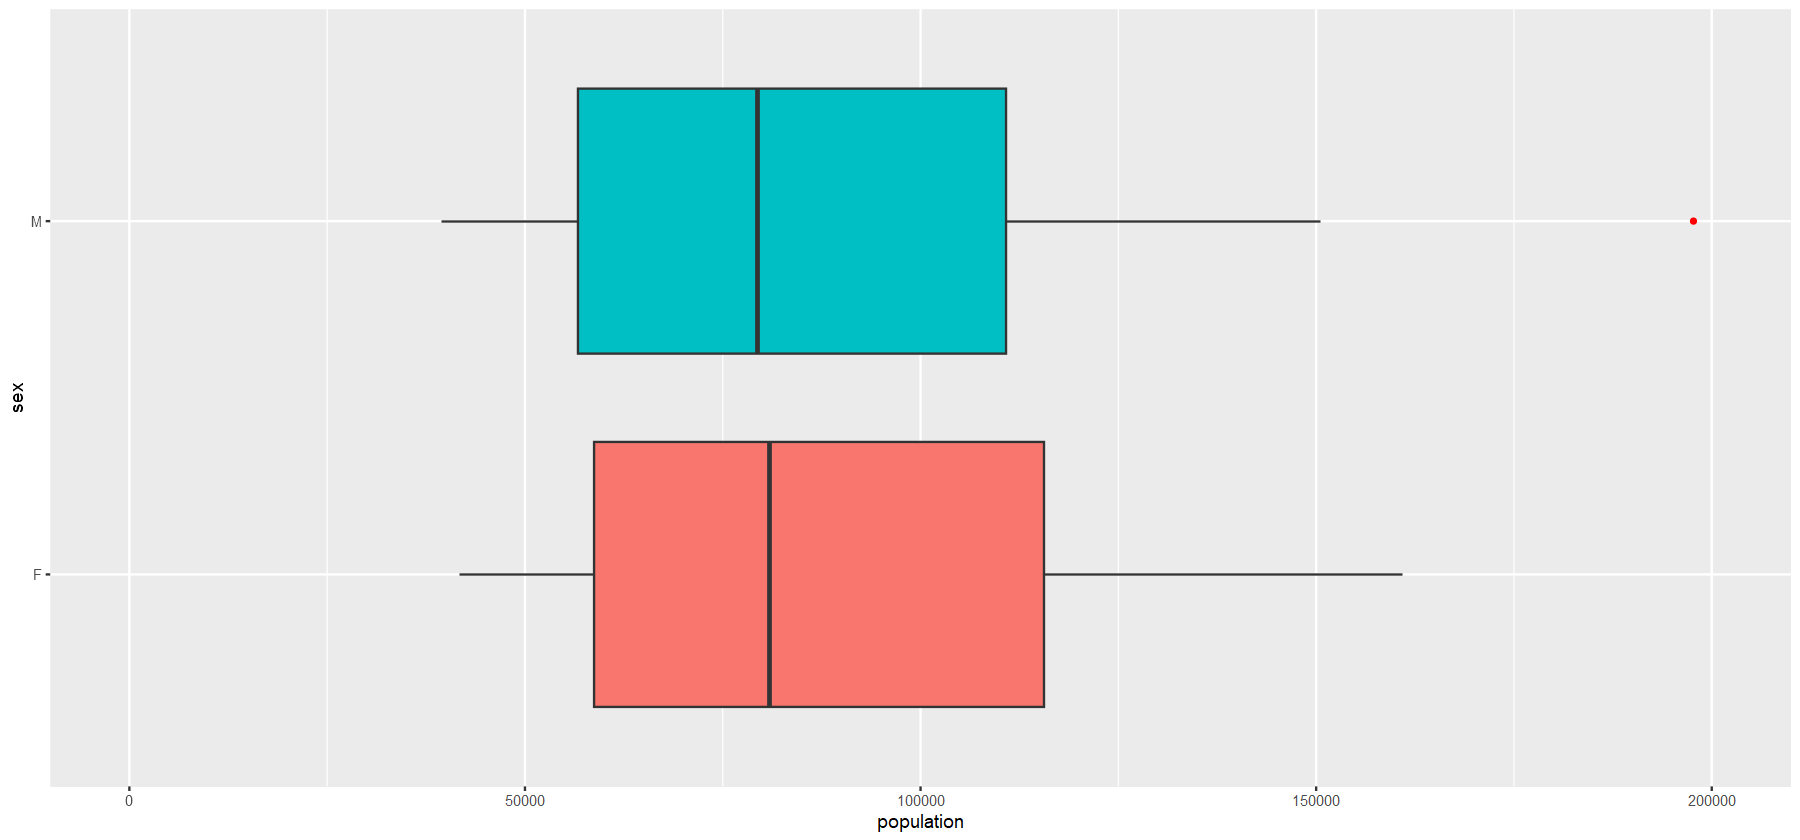

In [14]:
p %+% xlim(0, 200000)

Tady už je rozdíl mezi muži a ženami vidět trochu lépe. Vypadá to, že žen v regionech Bulharska bývá o něco více než mužů.

Abychom více poruzmněli rozdělení dat, zobrazíme si také *violin plot*

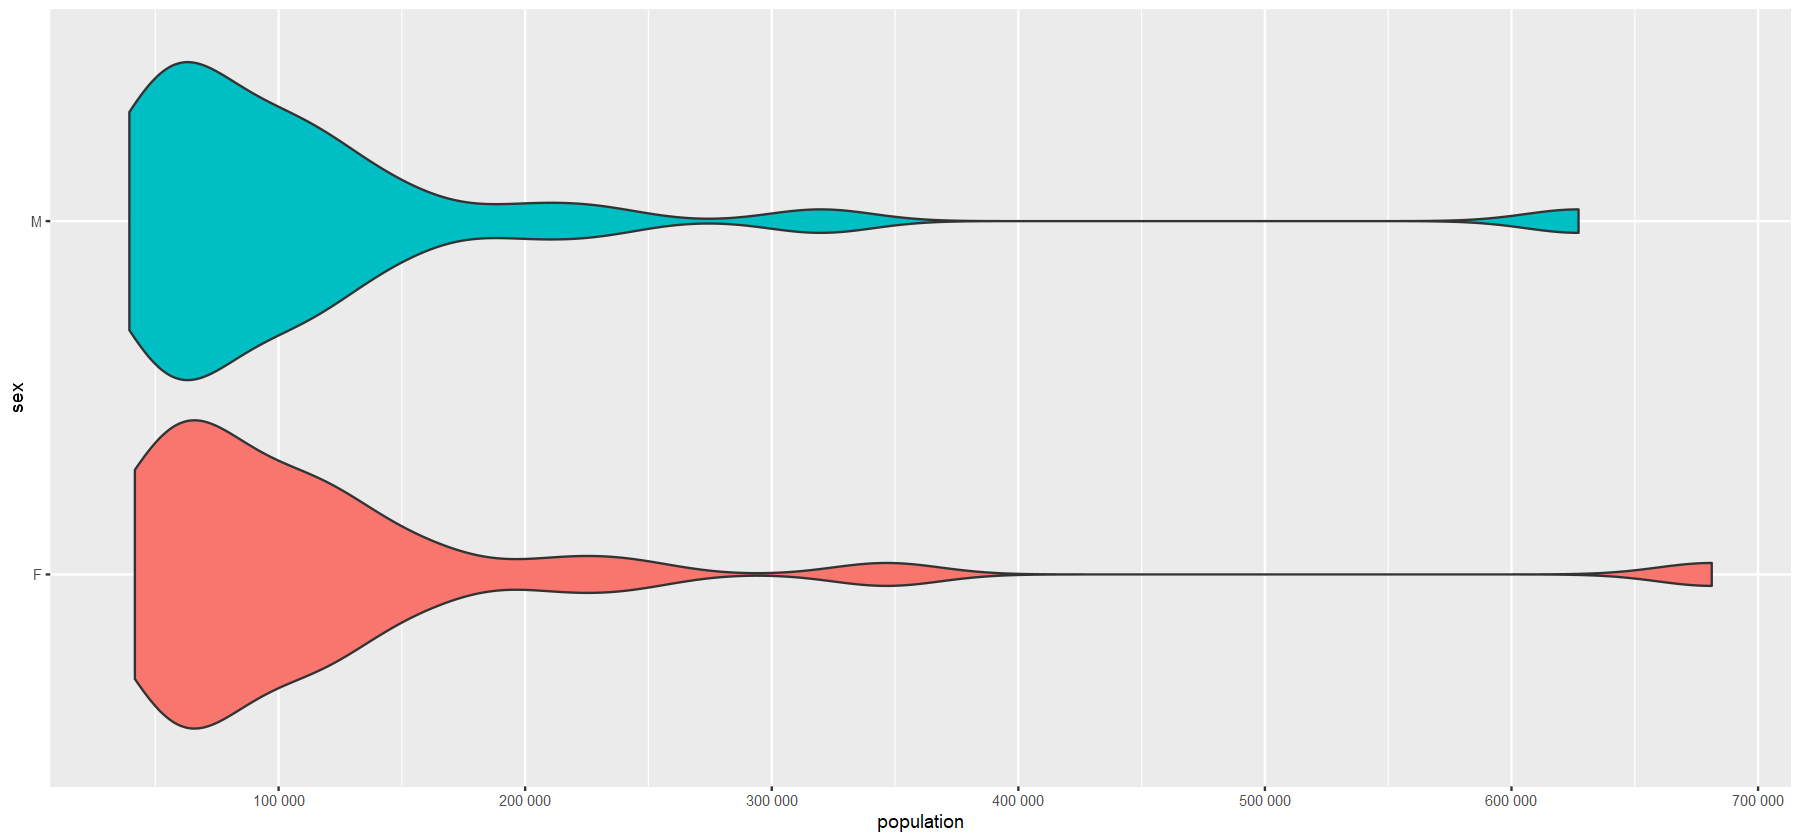

In [15]:
p = ggplot(nuts3_total, aes(x=population, y=sex, fill=sex)) +
        geom_violin(show.legend=F) + 
        scale_x_continuous(labels = scales::number, n.breaks=10)
plot(p)

Distribuce vypadají u mužů i žen opět podobně. Nejčastější velikost populace regionu je někde okolo 70 tisíc a poté četnost s rostoucími čísly klesá. Opět je vidět pár odlehlých hodnot a je vidět lehčí převaha žen, co se týče velikosti populace

Mohli bychom si zkusit porovnat věkové skupiny mužů a žen, jestli mezi nimi nejsou zajímavé rozdíly.

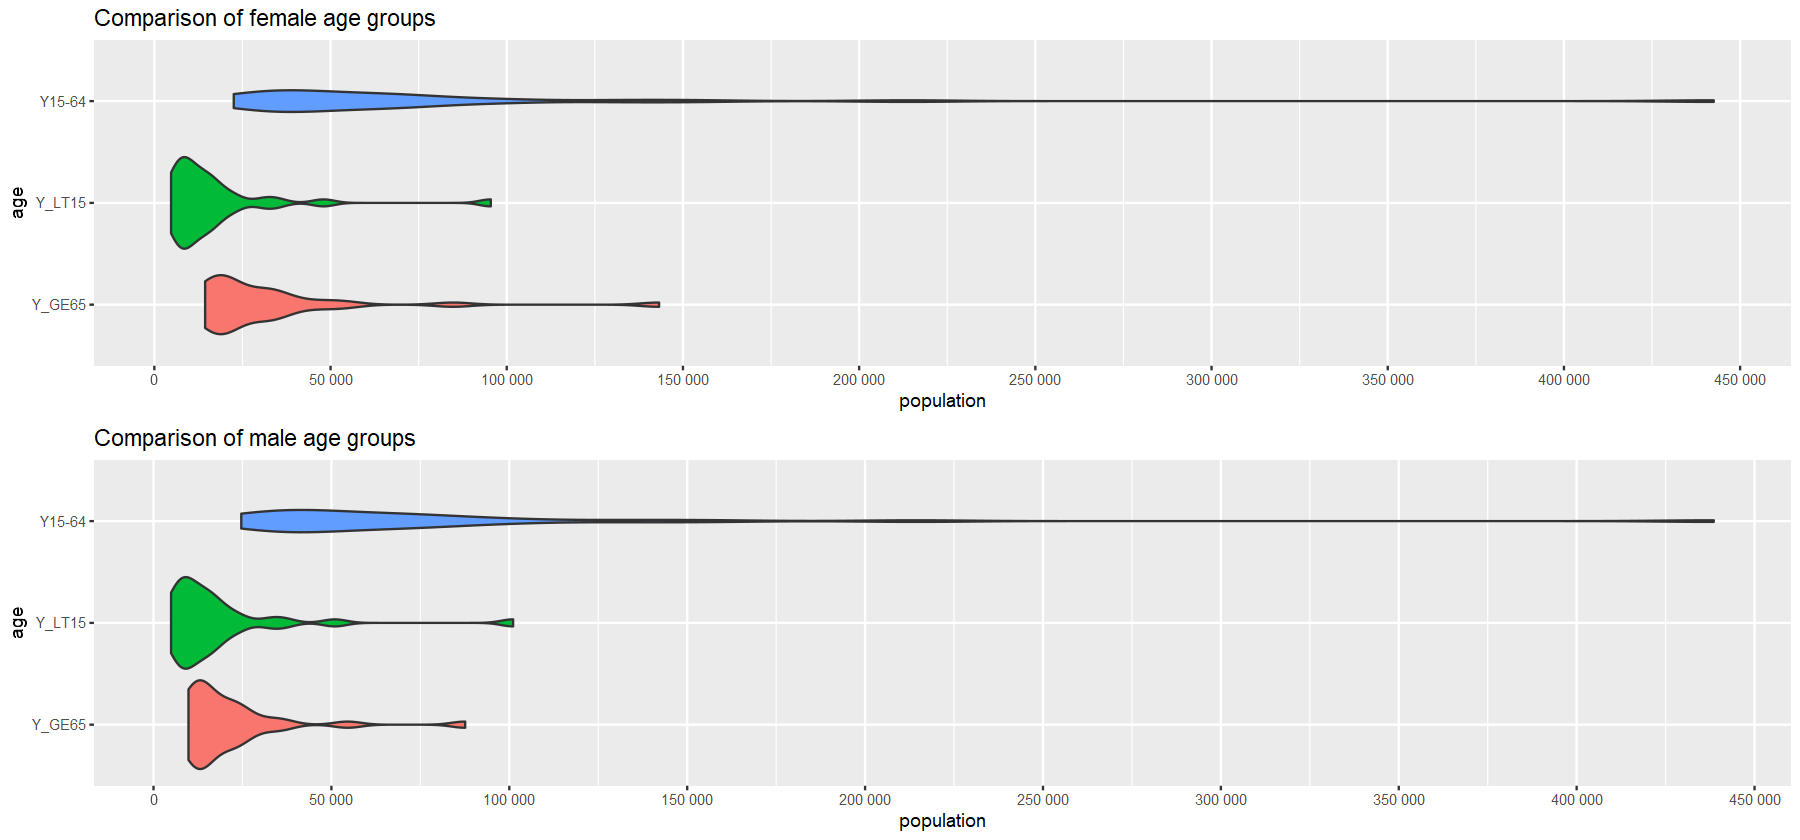

In [16]:
pF = ggplot(subset(nuts3, sex=="F" & age!="TOTAL"), aes(x=population, y=age, fill=age)) +
        geom_violin(show.legend=F) + 
        scale_x_continuous(labels = scales::number, n.breaks=10) +
        ggtitle("Comparison of female age groups")
pM = ggplot(subset(nuts3, sex=="M" & age!="TOTAL"), aes(x=population, y=age, fill=age)) +
        geom_violin(show.legend=F) + 
        scale_x_continuous(labels = scales::number, n.breaks=10) +
        ggtitle("Comparison of male age groups")
pg = plot_grid(pF, pM, nrow=2)
plot(pg)

Co se týče velikosti populace, ženy mají převahu zejména ve skupině 65+, tato složka populace je v jednotlivých regionech vyšší, než stejná skupina opačného pohlaví. Je to vidět na rozděleních obou těchto skupin; rozdělení žen 65+ je více vpravo a je více roztažené směrem do prava. Pojdmě se kouknout pomocí funkce `sumtable` na základní statistické rozdíly mezi muži a ženy v této kategorii.

In [30]:
sumtable(subset(nuts3, age == "Y_GE65", select=c("population","sex")), 
         out="return", summ=summ, group="sex", group.long=T, factor.numeric=TRUE)

Variable,Mean,Sd,Min,Pctile[25],Median,Pctile[75],Max,IQR,Skewness,Kurtosis-3
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
sex: F,,,,,,,,,,
population,32259.4,26627.616,14409,18499.75,22812.5,33623.25,143227,15123.5,2.96,9.248
,,,,,,,,,,
sex: M,,,,,,,,,,
population,21456.6,16352.804,9830,12246.25,15430.5,23426.5,87597,11180.25,2.748,8.033


Můžeme tu například vidět, že data žen v kategorii 65+ jsou více rozptýlená a že hodnota průměru je vyší.

Ve skupině 15-64 je jeden velmi výrazný outlier, kde má tato skupina ekonomicky aktivních obyvatel asi největší převahu. Zjistíme si, co to je za region. 

In [18]:
nuts3_Y15_64_F = nuts3[nuts3$age == 'Y15-64' & nuts3$sex=='F', ]
nuts3_Y15_64_F[which.max(nuts3_Y15_64_F$population),]
nuts3_Y15_64_M = nuts3[nuts3$age == 'Y15-64' & nuts3$sex=='M', ]
nuts3_Y15_64_M[which.max(nuts3_Y15_64_M$population),]

sex,age,geo,population
<fct>,<fct>,<chr>,<dbl>
F,Y15-64,BG411,442509


sex,age,geo,population
<fct>,<fct>,<chr>,<dbl>
M,Y15-64,BG411,438529


V obou případech to je region BG411, který odpovídá hlavnímu městu Bulharska - Sofii.

### Úloha 2

Z průzkumu dat výše máme podezření, že žen bývá v regionech v Bulharsku více než mužů. Otestujeme tedy, jestli se střední hodnoty počtu mužů a žen rovnají. K tomu bychom chtěli použít dvouvýběrový t-test. Tento test ale předpokládá, že jednotlivé výběry jsou z normálního rozdělení a jejich rozptyly jsou stejné. Nejdříve tedy otestujeme hypotézu, jestli naše data pocházejí z normálního rozdělení. K tomu použijeme Shapirův-Wilkův test:

- $H_0$: počet žen v NUTS3 regionech Bulharska je výběr z normálního rozdělení
- $H_A$: počet žen v NUTS3 regionech Bulharska není výběr z normálního rozdělení

In [19]:
nuts3_total_females = nuts3[nuts3$sex == 'F', ]
nuts3_total_males = nuts3[nuts3$sex == 'M', ]

shapiro.test(nuts3_total_females$population)


	Shapiro-Wilk normality test

data:  nuts3_total_females$population
W = 0.5664, p-value < 2.2e-16


- $H_0$: počet mužů v NUTS3 regionech Bulharska je výběr z normálního rozdělení
- $H_A$: počet mužů v NUTS3 regionech Bulharska není výběr z normálního rozdělení

In [20]:
shapiro.test(nuts3_total_males$population)


	Shapiro-Wilk normality test

data:  nuts3_total_males$population
W = 0.57482, p-value < 2.2e-16


U obou pohlaví nám vychází velmi malá $p$ hodnota a proto obě nulové hypotézy zamítame ve prospěch alternativ. Znamená to, že populace mužů a žen nejspíše nepochází z normálního rozdělení a proto nemůžeme použít dvouvýběrový t-test.

Pro lepší znázornění distribuce si zobrazíme i Q-Q plot.

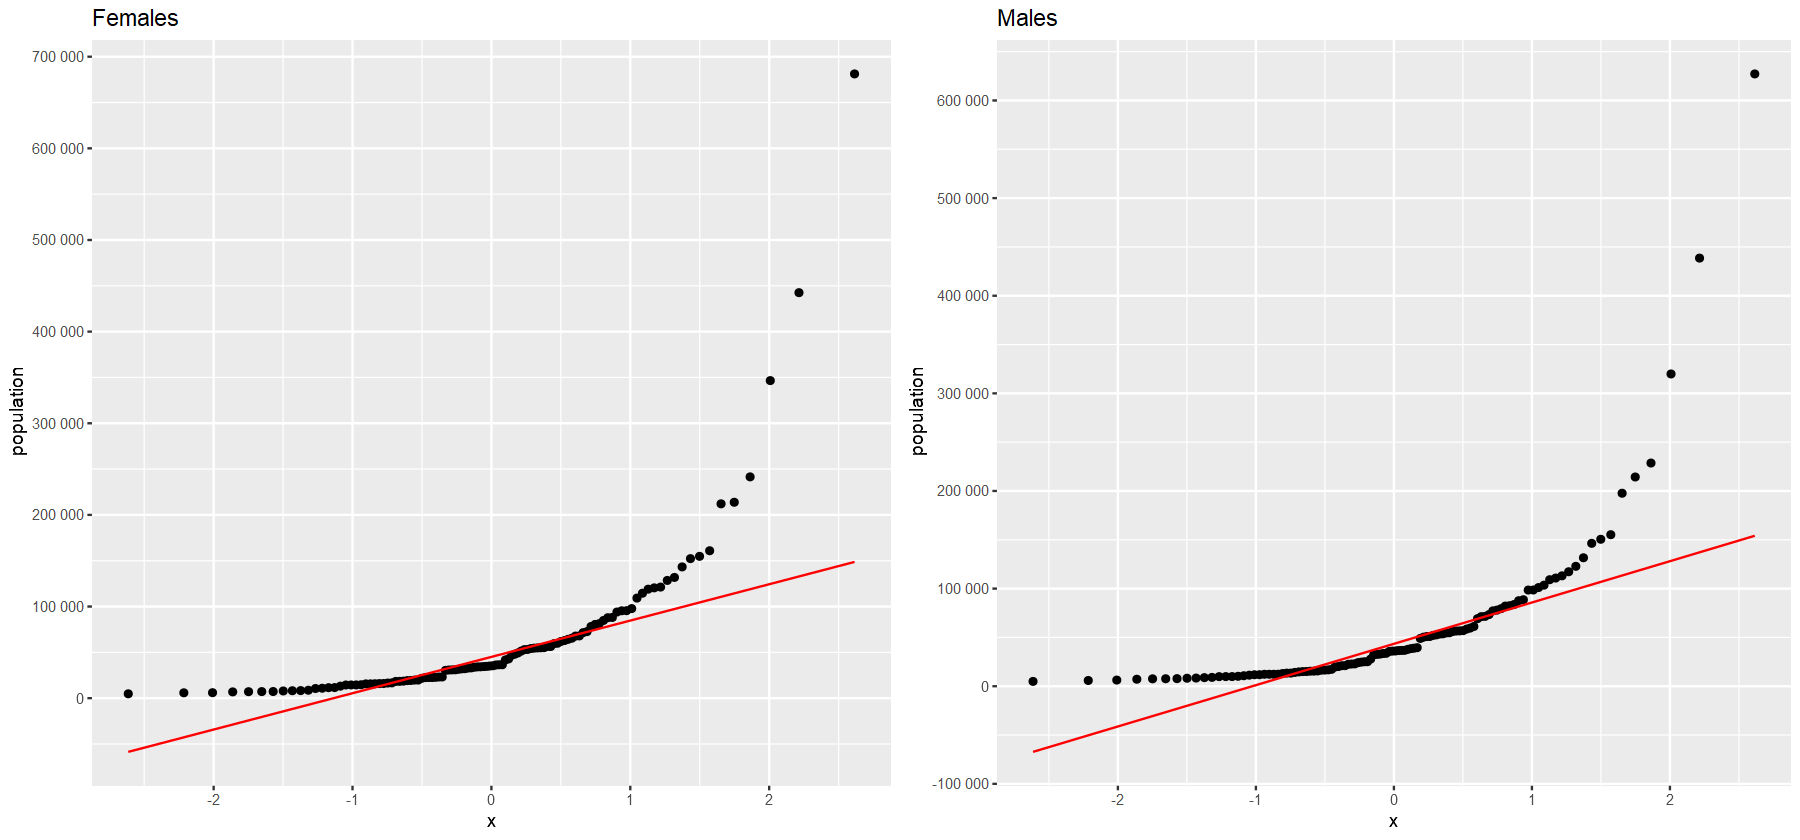

In [21]:
qq_f = ggplot(nuts3_total_females, aes(sample=population)) +
    stat_qq(distribution=qnorm) +
    stat_qq_line(distribution=qnorm, col='red') +
    scale_y_continuous(labels = scales::number, n.breaks=10) +
    labs(title = "Females", y = "population")
qq_m = ggplot(nuts3_total_males, aes(sample=population)) +
    stat_qq(distribution=qnorm) +
    stat_qq_line(distribution=qnorm, col='red') +
    scale_y_continuous(labels = scales::number, n.breaks=10) +
    labs(title = "Males", y = "population")
plot_grid(qq_f, qq_m)

I z Q-Q plotů je vidět, že kvantily našich výběrů teoretickým kvantilům normálního rozdělení neodpovídají a s rostoucími hodnotami se odchylka pouze zvyšuje. Naše data tedy pravděpodobně z normálního rozdělení opravdu nejsou.

Otestujeme si alespoň, jestli jsou počty mužů a žen ze stejného rozdělení. K tomu využijeme Mannův-Whitneyův U test. Předpokládáme, že počet mužů v regionu pochází z nějakého spojitého rozdělení $F$ a počet žen z nějakého spojitého rozdělení $G$. Potom stanovíme následující hypotézy:
- $H_0$: $F=G$
- $H_A$: $F\ne G$

In [22]:
wilcox.test(population ~ sex, data=nuts3_total)


	Wilcoxon rank sum exact test

data:  population by sex
W = 430, p-value = 0.5418
alternative hypothesis: true location shift is not equal to 0


Nulovou hypotézu nezamítáme. Tedy nezamítáme, že počty mužů a žen mohou být ze stejného rozdělení.

Dále bychom chtěli otestovat, zda-li mezi počty příslušníků skupiny obyvatel schopné plodit potomky a dětí v jednotlivých regionech neexistuje vztah - populace plodné skupiny obyvatel by mohla mít vliv na to, jak veliká je populace dětí. Použijeme Spearmanův korelační koeficient, jelikož naše rozdělení není normální.

- $H_0: \rho_S = 0$
- $H_A: \rho_S \ne 0$

In [23]:
nuts3_Y15_64 = nuts3[nuts3$age == 'Y15-64', ]
nuts3_Y_LT15 = nuts3[nuts3$age == 'Y_LT15', ]
cor.test(nuts3_Y15_64$population, nuts3_Y_LT15$population, method='spearman')


	Spearman's rank correlation rho

data:  nuts3_Y15_64$population and nuts3_Y_LT15$population
S = 784, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.9732057 


Nulovou hypotézu zamítáme ve propěch alternativy, která tvrdí, že populace obou skupin v jednotlivých regionech korelují, korelační koeficient je kladný a blízký k 1, což značí, že mezi populací dětí a dospělých existuje kladný vztah - větší populace dospělých vede k většímu počtu narozených dětí.

Závěrem bychom chtěli zjistit, zda-li jsou muži i ženy stejně rozděleni do věkových skupin. Využijeme Kolmogorovova-Smirnovova dvouvýběrového testu, protože je méně citlivý na posunutí výběrů a na různé odchylky tvaru či rozptylu.

Předpokládáme, že výběr mužů i žen pocházejí ze spojitých rozdělení s distribučními funkcemi $F$ a $G$. Testujeme hypotézu

- $H_0$: $F=G$
- $H_A$: $F\ne G$


In [24]:
ks.test(population ~ sex, data=nuts3[nuts3$age == 'Y_GE65', ])
ks.test(population ~ sex, data=nuts3[nuts3$age == 'Y15-64', ])
ks.test(population ~ sex, data=nuts3[nuts3$age == 'Y_LT15', ])


	Exact two-sample Kolmogorov-Smirnov test

data:  population by sex
D = 0.42857, p-value = 0.01089
alternative hypothesis: two-sided



	Exact two-sample Kolmogorov-Smirnov test

data:  population by sex
D = 0.17857, p-value = 0.7732
alternative hypothesis: two-sided



	Exact two-sample Kolmogorov-Smirnov test

data:  population by sex
D = 0.10714, p-value = 0.998
alternative hypothesis: two-sided


U skupin 15- a 15-64 nulovou hypotézu nezamítáme, ale u skupiny 65+ ji zamítáme. Nejspíš platí staré dobré pravidlo, že se ženy dožívají vyššího věku než muži.

### Úloha 3

Vytvoříme kontingenční tabulku. Použijeme k tomu oblasti NUTS3, populaci a pohlaví. Věk nebudeme omezovat.

In [25]:
nuts3_total["age"] = NULL
head(nuts3_total)

sex,geo,population
<fct>,<chr>,<dbl>
F,BG311,41725
F,BG312,64229
F,BG313,80441
F,BG314,120356
F,BG315,62910
F,BG321,118915


In [26]:
ct = xtabs(formula=population ~ sex + geo, data=nuts3_total)
addmargins(ct)

,BG311,BG312,BG313,BG314,BG315,BG321,BG322,BG323,BG324,BG325,⋯,BG412,BG413,BG414,BG415,BG421,BG422,BG423,BG424,BG425,Sum
F,41725,64229,80441,120356,62910,118915,54914,109208,56343,54803,⋯,121215,154769,61876,59920,346547,114498,128479,52947,81351,3566833
M,39487,61166,77196,113082,59580,110803,50874,103521,53467,52049,⋯,117261,146369,58550,56699,319851,109127,122821,48940,79430,3349715
Sum,81212,125395,157637,233438,122490,229718,105788,212729,109810,106852,⋯,238476,301138,120426,116619,666398,223625,251300,101887,160781,6916548


Na první pohled je vidět, že žen je více než mužů snad v každém regionu. Podíváme se ještě na matici pravděpodobnosti. Pro lepší čitelnost pravděpodobnosti zaokrouhlíme.

In [27]:
prop = addmargins(prop.table(ct))
round(prop, 4)

,BG311,BG312,BG313,BG314,BG315,BG321,BG322,BG323,BG324,BG325,⋯,BG412,BG413,BG414,BG415,BG421,BG422,BG423,BG424,BG425,Sum
F,0.0060,0.0093,0.0116,0.0174,0.0091,0.0172,0.0079,0.0158,0.0081,0.0079,⋯,0.0175,0.0224,0.0089,0.0087,0.0501,0.0166,0.0186,0.0077,0.0118,0.5157
M,0.0057,0.0088,0.0112,0.0163,0.0086,0.0160,0.0074,0.0150,0.0077,0.0075,⋯,0.0170,0.0212,0.0085,0.0082,0.0462,0.0158,0.0178,0.0071,0.0115,0.4843
Sum,0.0117,0.0181,0.0228,0.0338,0.0177,0.0332,0.0153,0.0308,0.0159,0.0154,⋯,0.0345,0.0435,0.0174,0.0169,0.0963,0.0323,0.0363,0.0147,0.0232,1.0000


Z matice pravděpodobnosti je převaha žen vidět ještě lépe.

Provedeme $\chi^2$ test nezávislosti počtu obyvatel v regionu na pohlaví.
- $H_0$: počet obyvatel v regionu nezávisí na pohlaví
- $H_A$: neplatí $H_0$

In [28]:
test = chisq.test(ct)
test


	Pearson's Chi-squared test

data:  ct
X-squared = 420.37, df = 27, p-value < 2.2e-16


Hodnota *p-value* se blíží 0 a proto zamítáme nulovou hypotézu ve prospěch alternativy. Znamená to, že pohlaví a počet obyvatel v regionu nejsou nezávislé veličiny.

Zobrazíme si srovnání tabulky očekávaných hodnot (při nezávislosti rozdělení mužů a žen) a našich původních hodnot.

In [29]:
addmargins(ct - test$expected)

,BG311,BG312,BG313,BG314,BG315,BG321,BG322,BG323,BG324,BG325,⋯,BG412,BG413,BG414,BG415,BG421,BG422,BG423,BG424,BG425,Sum
F,-155.6667,-436.643,-851.6988,-26.93696,-257.5475,450.4505,359.5995,-495.3979,-285.5279,-300.1005,⋯,-1766.011,-526.5254,-227.1519,-219.8989,2888.519,-824.4166,-1115.291,404.3279,-1563.046,-4.365575e-11
M,155.6667,436.643,851.6988,26.93696,257.5475,-450.4505,-359.5995,495.3979,285.5279,300.1005,⋯,1766.011,526.5254,227.1519,219.8989,-2888.519,824.4166,1115.291,-404.3279,1563.046,4.365575e-11
Sum,0.0000,0.000,0.0000,0.00000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,⋯,0.000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.000000e+00


Je vidět, že se hodnoty v tabulkách dost liší, jak bylo očekávano z výsledku testu.